In [20]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/Julia/tinympc-julia/quadrotor_quat/Project.toml`


In [21]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random
using Printf
using ControlSystems

In [22]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

# Force-Torque-Controlled Model

In [64]:
#Quadrotor parameters
m = 0.027
arm = 0.046
J = [16.6e-6 0.83e-6 0.72e-6;
     0.83e-6 16.6e-6 1.8e-6;
     0.72e-6 1.8e-6 29.3e-6];
# J = Array(diagm([1.4194e-05, 1.4089e-05, 2.9741e-05]))
g = 9.81

h = 1/50 #500 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12
Nu = 4     # number of controls
Tfinal = 3.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)
thist = Array(range(0,h*(Nt-1), step=h));

In [65]:
function quad_dynamics(x,u)
    r = x[1:3]
    q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
    v = x[8:10]
    ω = x[11:13]
    Q = qtoQ(q)
    
    ṙ = Q*v
    q̇ = 0.5*L(q)*H*ω
    
    v̇ = Q'*[0; 0; -g] + (1/m)*[0; 0; u[1]] - hat(ω)*v
    
    ω̇ = J\(-hat(ω)*J*ω + u[2:4])
    
    return [ṙ; q̇; v̇; ω̇]
end

quad_dynamics (generic function with 1 method)

In [66]:
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [67]:
#Initial Conditions
# uhover = (m*g/4)*ones(4)
uhover = [m*g; 0; 0; 0]
r0 = [0.0; 0; 1.0]
q0 = [1.0; 0; 0; 0]
v0 = zeros(3)
ω0 = zeros(3)
x0 = [r0; q0; v0; ω0];

In [68]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),x0)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(x0,u),uhover);
#Reduced system
Ã = Array(E(q0)'*A*E(q0))
B̃ = Array(E(q0)'*B);

In [69]:
# # Cost weights/Bryson's rules
# max_dev_x = [0.05; 0.05; 0.05;  0.05; 0.05; 0.05;  0.1; 0.1; 0.1;  0.1; 0.1; 0.1]
# max_thrust = 60*1e-3*9.81/2
# max_torque_x = max_thrust*arm/2
# max_torque_z = thrustToTorque*max_thrust/2
# max_dev_u = [max_thrust; max_torque_x; max_torque_x; max_torque_z]/6
# # Q = Array(diagm([10, 10, 10,  1, 1, 0.1,  1, 1, 1,  1, 1, 0.1]));
# Q = Array(diagm(1 ./(max_dev_x.^2)))
# # R = Array(0.2*I(Nu));
# R = Array(diagm(1 ./(max_dev_u.^2)))
# #LQR Controller
# K = dlqr(Ã,B̃,Q,R)

In [120]:
# Saved
max_dev_x = [0.05; 0.05; 0.05;  0.05; 0.05; 0.05;  0.1; 0.1; 0.1;  0.1; 0.1; 0.1]
max_thrust = 60*1e-3*9.81/2  # divided by 2 because this is Δu
thrustToTorque = 0.005964552
arm = 0.046/sqrt(2)
max_torque_x = max_thrust*arm/2  # divided by 2 because only two effective torques
max_torque_z = thrustToTorque*max_thrust
max_dev_u = [max_thrust; max_torque_x; max_torque_x; max_torque_z]/6
# Q = Array(diagm([10, 10, 10,  1, 1, 0.1,  1, 1, 1,  1, 1, 0.1]));
Q = Array(diagm(1 ./(max_dev_x.^2)))
# R = Array(0.2*I(Nu));
R = Array(diagm(1 ./(max_dev_u.^2)))
#LQR Controller
K = dlqr(Ã,B̃,Q,R)

4×12 Matrix{Float64}:
 -1.90677e-11   1.32764e-10   0.803438     …  6.62633e-14  -1.07998e-12
  7.43874e-5   -0.00154404   -8.149e-14       4.21545e-5    2.65826e-5
  0.00154156   -7.44214e-5   -2.48366e-12     0.00087006    6.73328e-5
  0.000133461  -5.31883e-5   -1.44688e-13     7.73756e-5    0.00122929

In [131]:
R

4×4 Matrix{Float64}:
 415.644  0.0        0.0        0.0
   0.0    1.57143e6  0.0        0.0
   0.0    0.0        1.57143e6  0.0
   0.0    0.0        0.0        1.16833e7

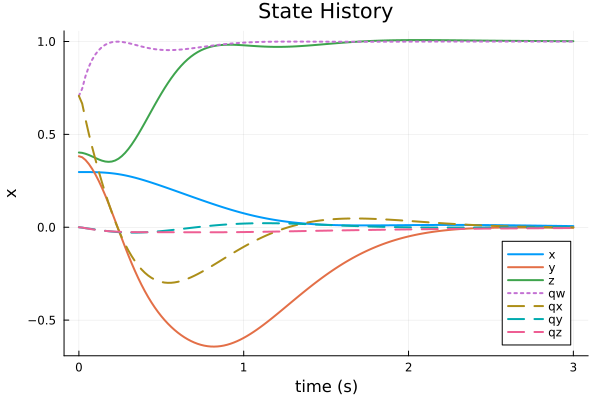

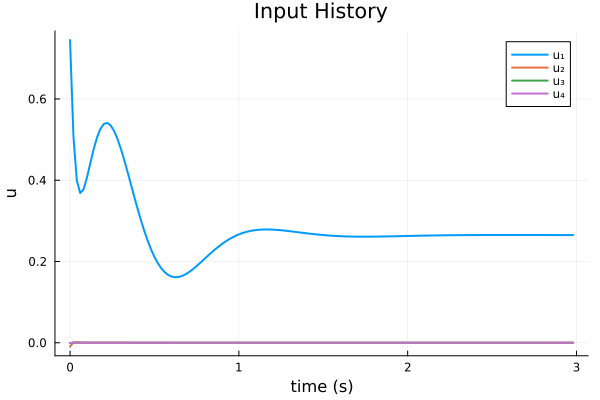

In [121]:
#Feedback controller
function controller(x)
    
    q0 = x0[4:7]
    q = x[4:7]
    ϕ = qtorp(L(q0)'*q)
    
    Δx̃ = [x[1:3]-r0; ϕ; x[8:10]-v0; x[11:13]-ω0]
    
    u = uhover - K*Δx̃
end
#Simulation
Random.seed!(1);
uhist = zeros(Nu,Nt-1)
xhist = zeros(Nx,Nt)
xhist[:,1] = [r0+randn(3); L(q0)*rptoq([1; 0; 0]); v0; ω0]
for k = 1:(Nt-1)
    uhist[:,k] = controller(xhist[:,k])
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],uhist[:,k])
end
display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz" ],
linestyle=[:solid :solid :solid :dot :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],uhist',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))

In [122]:
xhist[1:3,Nt] - r0

3-element Vector{Float64}:
  0.006175995742120665
 -0.002789987653077263
  0.0016770850090761513

In [123]:
# #Set up visualization
# using TrajOptPlots
# using MeshCat
# using StaticArrays
# using RobotZoo:Quadrotor

# vis = Visualizer()
# render(vis)

In [124]:
# model = Quadrotor()
# TrajOptPlots.set_mesh!(vis, model)

In [125]:
# X1 = [SVector{13}(x) for x in eachcol(xhist)];
# visualize!(vis, model, thist[end], X1)

In [126]:
scale = 65535
display(K)
# C Language
@printf("FOR C:\n");
str = "static float K[NU][NXt] = {\n"
for i = 1:4
  str = str * "  {"
  for j = 1:12
    # if abs(K[i, j]) < 1e-6
    #   K[i, j] = 0.0
    # end
    this_str = @sprintf("%.6f", K[i, j]*scale)

    str = str * this_str * "f"
    if j < 12
      str = str * ","
    end
  end
  str = str * "},\n"
end
str = str * "};"
@printf("%s",str)

@printf("\n\nFOR PYTHON:\n");
# Python Language
str = "K = np.array([\n"
for i = 1:4
  str = str * "  ["
  for j = 1:12
    # if abs(K[i, j]) < 1e-6
    #   K[i, j] = 0.0
    # end
    this_str = @sprintf("%.6f", K[i, j]*scale)

    str = str * this_str 
    if j < 12
      str = str * ","
    end
  end
  str = str * "],\n"
end
str = str * "])"
@printf("%s",str)


4×12 Matrix{Float64}:
 -1.90677e-11   1.32764e-10   0.803438     …  6.62633e-14  -1.07998e-12
  7.43874e-5   -0.00154404   -8.149e-14       4.21545e-5    2.65826e-5
  0.00154156   -7.44214e-5   -2.48366e-12     0.00087006    6.73328e-5
  0.000133461  -5.31883e-5   -1.44688e-13     7.73756e-5    0.00122929

FOR C:
static float K[NU][NXt] = {
  {-0.000001f,0.000009f,52653.331606f,-0.000031f,-0.000007f,-0.000009f,-0.000001f,0.000006f,29655.145945f,-0.000000f,0.000000f,-0.000000f},
  {4.874978f,-101.188832f,-0.000000f,659.749216f,31.851603f,3.390918f,4.665786f,-96.773025f,0.000000f,57.101199f,2.762597f,1.742091f},
  {101.025950f,-4.877204f,-0.000000f,31.865278f,658.744522f,8.592149f,96.620276f,-4.667871f,-0.000000f,2.763709f,57.019366f,4.412653f},
  {8.746378f,-3.485695f,-0.000000f,23.035438f,57.786754f,157.328755f,8.404659f,-3.349809f,-0.000000f,2.021870f,5.070811f,80.561687f},
};



FOR PYTHON:
K = np.array([
  [-0.000001,0.000009,52653.331606,-0.000031,-0.000007,-0.000009,-0.000001,0.000006,29655.145945,-0.000000,0.000000,-0.000000],
  [4.874978,-101.188832,-0.000000,659.749216,31.851603,3.390918,4.665786,-96.773025,0.000000,57.101199,2.762597,1.742091],
  [101.025950,-4.877204,-0.000000,31.865278,658.744522,8.592149,96.620276,-4.667871,-0.000000,2.763709,57.019366,4.412653],
  [8.746378,-3.485695,-0.000000,23.035438,57.786754,157.328755,8.404659,-3.349809,-0.000000,2.021870,5.070811,80.561687],
])

# PWM-Controlled Model

In [127]:
# m = 0.03
# ℓ = 0.046
# J = [16.6e-6 0.83e-6 0.72e-6;
#     0.83e-6 16.6e-6 1.8e-6;
#     0.72e-6 1.8e-6 29.3e-6];
# g = 9.81
# thrustToTorque = 0.005964552
# ℓ = 0.046/sqrt(2)
# scale = 65535
# kt = 2.245365e-7*scale*g # u is PWM in range [0...1]
# km = kt*thrustToTorque #4.4733e-8


# h = 1/50 #50 Hz

# Nx = 13     # number of states (quaternion)
# Nx̃ = 12     # number of states (linearized)
# Nu = 4     # number of controls
# nx = Nx̃
# nu = Nu
# Tfinal = 5.0 # final time
# Nt = Int(Tfinal/h)+1    # number of time steps
# t_vec = h*(0:Nt-1)
# thist = Array(range(0,h*(Nt-1), step=h));

# function quad_dynamics(x,u)
#   r = x[1:3]
#   q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
#   v = x[8:10]
#   ω = x[11:13]
#   Q = qtoQ(q)
  
#   ṙ = Q*v
#   q̇ = 0.5*L(q)*H*ω
  
#   v̇ = Q'*[0; 0; -g] + (1/m)*[zeros(2,4); kt*ones(1,4)]*u - hat(ω)*v
  
#   ω̇ = J\(-hat(ω)*J*ω + [-ℓ*kt -ℓ*kt ℓ*kt ℓ*kt; ℓ*kt -ℓ*kt -ℓ*kt ℓ*kt; -km km -km km]*u)
  
#   return [ṙ; q̇; v̇; ω̇]
# end
# function quad_dynamics_rk4(x,u)
#   #RK4 integration with zero-order hold on u
#   f1 = quad_dynamics(x, u)
#   f2 = quad_dynamics(x + 0.5*h*f1, u)
#   f3 = quad_dynamics(x + 0.5*h*f2, u)
#   f4 = quad_dynamics(x + h*f3, u)
#   xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
#   xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
#   return xn
# end
# #Goal state
# uhover = (0.5)*ones(4)  # m = 30g and max thrust = 60g
# rg = [0.0; 0; 1.0]
# qg = [1.0; 0; 0; 0]
# vg = zeros(3)
# ωg = zeros(3)
# xg = [rg; qg; vg; ωg];

In [128]:
# #Linearize dynamics about hover
# A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
# B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
# Ã = Array(E(qg)'*A*E(qg))
# B̃ = Array(E(qg)'*B);
# function discrete_dynamics(params,x,u,k)
#   Ã*x + B̃*u 
# end

In [129]:
# # Saved
# max_dev_x = [0.05; 0.05; 0.05;  0.05; 0.05; 0.05;  0.1; 0.1; 0.1;  0.1; 0.1; 0.1]
# max_dev_u = [0.5; 0.5; 0.5; 0.5]/6
# # Q = Array(diagm([10, 10, 10,  1, 1, 0.1,  1, 1, 1,  1, 1, 0.1]));
# Q = Array(diagm(1 ./(max_dev_x.^2)))
# # R = Array(0.2*I(Nu));
# R = Array(diagm(1 ./(max_dev_u.^2)))
# #LQR Controller
# K = dlqr(Ã,B̃,Q,R)